In [1]:
import pickle 
import sqlite3

import numpy as np

from matplotlib import pyplot as plt, rcParams, patches as mplPatches, lines as mplLines
from matplotlib.axes import Axes as mplAxes

rcParams["font.size"] = 8
rcParams["font.family"] = "Roboto Condensed"

from rdkit import Chem
from rdkit.Chem.rdmolops import RDKFingerprint
from sklearn.decomposition import PCA, KernelPCA

import umap

ModuleNotFoundError: No module named 'umap'

In [85]:
def prop_hist(counts, bins, xlab, figname=None, ax=None, alpha=1., 
              save_show_close=False, log_y=False, color="#353535",
              step=False):
    if ax is None:
        fig, ax = plt.subplots(figsize=(3.5, 1.5))
        for d in ["top", "right"]:
            ax.spines[d].set_visible(False)
        ax.set_xlabel(xlab)
        ax.set_ylabel("entries")
        if log_y:
            ax.set_yscale("log")
    if counts is not None:
        if step:
            _ = ax.hist(counts, bins, color=color, alpha=alpha, histtype="step", lw=1)
        else:
            _ = ax.hist(counts, bins, color=color, alpha=alpha)
    if save_show_close:
        if figname is not None:
            plt.savefig(figname, dpi=400, bbox_inches="tight")
        plt.show()
        plt.close()
        return None
    return ax

In [106]:
def ms2_2d_hist(pres, frags, figname=None, bins=np.arange(50, 1001, 5)):
    fig, ((ax_mzh, ax_01, ax_02), (ax_2dh, ax_rth, ax_cb)) = plt.subplots(nrows=2, ncols=3, figsize=(4.25, 3.75), 
                                                                        width_ratios=[9, 1.8, 0.25], height_ratios=[1, 6.25])
    ax_01.axis('off')
    ax_02.axis('off')
    prebins = bins
    fragbins = bins
    h, xbins, ybins = np.histogram2d(pres, frags, bins=[prebins, fragbins])
    h /= max([max(_) for _ in h])
    #h, *_, himg = ax_2dh.hist2d(*feats, bins=[prebins, fragbins], cmap='inferno')
    extent = [prebins.min(), prebins.max(), fragbins.min(), fragbins.max()]
    mask = np.array([[ybin > xbin for ybin in ybins[:-1]] for xbin in xbins[:-1]])
    himg = ax_2dh.imshow(np.ma.masked_where(mask, h).T, 
                        interpolation='none', origin='lower', extent=extent, 
                        cmap="inferno", aspect="auto")
    #print(np.max(h))
    #for d in ['top', 'right']:
    #    ax.spines[d].set_visible(False)
    ax_2dh.set_xlabel('precursor m/z')
    ax_2dh.set_ylabel('fragment m/z')
    ax_mzh.hist(pres, bins=prebins, color='grey')
    ax_mzh.set_xlim([min(prebins), max(prebins)])
    ax_mzh.axis('off')
    ax_rth.hist(frags, bins=fragbins, orientation='horizontal', color='grey')
    ax_rth.set_ylim([min(fragbins), max(fragbins)])
    ax_rth.axis('off')
    cb = plt.colorbar(himg, cax=ax_cb)
    cb.set_label("density")
    fig.subplots_adjust(wspace=0, hspace=0)
    if figname is not None:
        plt.savefig(figname, dpi=400, bbox_inches='tight')
    plt.show()
    plt.close()

# Reference Only

In [2]:
con = sqlite3.connect("reference_only/idpp_cleaned.db")
cur = con.cursor()

In [86]:
qry = """--sqlite3
SELECT 
    adduct_mz
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_mz > 0
ORDER BY 
    adduct_mz
;"""
all_mzs = np.array(cur.execute(qry).fetchall()).ravel()

In [18]:
all_mzs

array([  46.    ,   46.    ,   52.0651, ..., 2833.8726, 2854.2133,
       2927.1981])

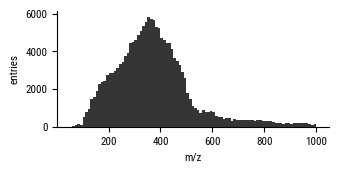

In [87]:
bins = [_ for _ in range(50, 1001, 10)]
prop_hist(all_mzs, bins, "m/z", figname="_figures/ref_only/mz_dist.png", save_show_close=True)

In [80]:
qry = """--sqlite3
SELECT 
    ccs
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
    JOIN CCSs USING(adduct_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
ORDER BY 
    ccs
;"""
all_ccs = np.array(cur.execute(qry).fetchall()).ravel()

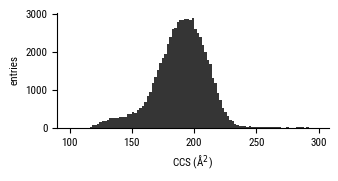

In [88]:
bins = [_ for _ in range(100, 300, 2)]
prop_hist(all_ccs, bins, "CCS (Å$^2$)", figname="_figures/ref_only/ccs_dist.png", save_show_close=True)

(186)
(374, 375)
(366, 367)
(260, 261)


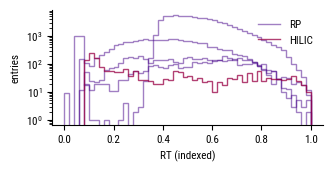

In [89]:
qry_src_ids = """--sqlite3
SELECT 
    src_id
FROM 
    RTs
    JOIN Sources USING(src_id)
GROUP BY 
    src_id
HAVING 
    src_notes LIKE '%"method": "{phase}"%'
    AND COUNT(*) >= 999
ORDER BY
    COUNT(*) DESC
;"""

qry_fetch_rts_by_src_ids = """--sqlite3
SELECT 
    rt
FROM
    RTs
WHERE
    src_id IN {}
;"""

bins = np.arange(0, 1.01, 0.02)
ax = prop_hist(None, None, "RT (indexed)", log_y=True)
# RP
# 186
# 374, 375
# 366, 367
# 260, 261
for src_ids in [
    "(186)", 
    (374, 375), 
    (366, 367), 
    (260, 261)
]:
    print(src_ids)
    rts = np.array(
        cur.execute(
            qry_fetch_rts_by_src_ids.format(src_ids)
        ).fetchall()
    ).ravel()
    prop_hist(rts / max(rts), bins, None, ax=ax, step=True, color="#440088", alpha=0.5)
# HILIC
# 227, 224
rts = np.array(cur.execute(qry_fetch_rts_by_src_ids.format((227, 224))).fetchall()).ravel()
prop_hist(rts / max(rts), bins, None, ax=ax, step=True, color="#990044", alpha=0.75)
#ax.set_ylim([0, 200])
# customized legend
lines = [
    mplLines.Line2D([0], [0], color="#440088", lw=1., alpha=0.5, label="RP"),
    mplLines.Line2D([0], [0], color="#990044", lw=1., alpha=0.75, label="HILIC")
]
ax.legend(handles=lines, frameon=False, loc="upper right")
prop_hist(None, None, None, ax=ax, save_show_close=True, figname="_figures/ref_only/RT_indexed_hists.png")

In [91]:
qry = """--sqlite3
SELECT 
    adduct_mz,
    frag_imz
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
    JOIN MS2Spectra USING(adduct_id)
    JOIN MS2Fragments USING(ms2_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_mz > 0
;"""
pres, frags = np.array(cur.execute(qry).fetchall()).T

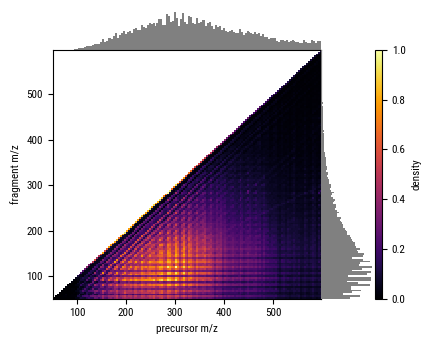

In [111]:
ms2_2d_hist(pres, frags / 1e5, figname="_figures/ref_only/msms_precursors_fragments_2d_hist.png", bins=np.arange(50, 601, 4))

In [3]:
qry = """--sqlite3
SELECT 
    DISTINCT smi 
FROM 
    Compounds 
    JOIN Adducts USING(cmpd_id) 
    LEFT JOIN Smiles USING(smi_id) 
    LEFT JOIN InChIs USING(inchi_id) 
WHERE 
    smi IS NOT NULL 
    AND smi !="INVALID"
;"""
smis = [_ for (_,) in cur.execute(qry).fetchall()]

In [4]:
# compute 1024 bit molecular fingerprints
fps = np.array(
    [
        [
            int(_) 
            for _ in RDKFingerprint(
                Chem.MolFromSmiles(smi), fpSize=1024
            )
        ] 
        for smi in smis
    ], 
    dtype=np.uint8
)
np.save("_cache/fps1024.npy", fps)

In [4]:
fps = np.load("_cache/fps1024.npy")

In [25]:
# fit the PCA, compute projections
pca = PCA(n_components=8, svd_solver='full', random_state=69).fit(fps)
fps_pca = pca.transform(fps)

In [26]:
fps_pca.shape

(98265, 8)

In [27]:
sum(pca.explained_variance_ratio_)

0.23577576553276153

In [28]:
pca.explained_variance_ratio_

array([0.14692552, 0.01747419, 0.01525526, 0.01333132, 0.01240744,
       0.01116184, 0.01032655, 0.00889366])

In [ ]:
# plot the explained variance ratios across the components
fig, ax = plt.subplots(figsize=(2.5, 1.5))

plt.show()
plt.close()

In [18]:
reducer = umap.UMAP(n_neighbors=80, metric="jaccard")
embedding = reducer.fit_transform(fps)
embedding.shape

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:1880: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/umap/umap_.py:127: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 80 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(


(98265, 2)

In [8]:
# make some heavy element counts
cnops = {
    6: [],   # C
    7: [],   # N
    8: [],   # O
    15: [],  # P
    16: [],  # S  
}
for smi in smis:
    mol_cnops = {
        6: 0,   # C
        7: 0,   # N
        8: 0,   # O
        15: 0,  # P
        16: 0,  # S
    }
    mol = Chem.MolFromSmiles(smi)
    for atom in mol.GetAtoms():
        if (anum := atom.GetAtomicNum()) in mol_cnops.keys():
            mol_cnops[anum] += 1
    for anum, cnt in mol_cnops.items():
        cnops[anum].append(cnt)

In [9]:
# convert the data to arrays to make using them easier
cnops = {
    k: np.array(v)
    for k, v in cnops.items()
}

In [10]:
# count up heavy atoms
hac = np.array([
    sum([
        1 if atm.GetAtomicNum() > 1 else 0 for atm in Chem.MolFromSmiles(smi).GetAtoms()
    ])
    for smi in smis
])

In [113]:
def project_with_color_by_prop(pc0_n, pc0, evr0, pc1_n, pc1, evr1, prop, prop_name, vmax=None, figname=None, vmin=None):
    # indices to sort by property 
    idx = np.argsort(prop)
    fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(4, 3.5), width_ratios=(20, 1))
    himg = ax.scatter(pc0[idx], pc1[idx], s=2, marker=".", c=prop[idx], 
                      linewidths=None, cmap="inferno", vmax=vmax, vmin=vmin)
    # xbins = np.linspace(min(fps_pca.T[0]), max(fps_pca.T[0]), 100)
    # ybins = np.linspace(min(fps_pca.T[1]), max(fps_pca.T[1]), 100)
    # ax: mplAxes
    # *_, himg = ax.hist2d(fps_pca.T[0], fps_pca.T[1], (xbins, ybins), cmap="inferno", norm="log")
    cb = plt.colorbar(himg, cax=axcb)
    cb.set_label(prop_name)
    for d in ["top", "bottom", "left", "right"]:
        ax.spines[d].set_visible(False)
    ax.set_xlabel(f"PC{pc0_n} ({evr0 * 100:.1f} %)")
    ax.set_ylabel(f"PC{pc1_n} ({evr1 * 100:.1f} %)")
    if figname is not None:
        plt.savefig(figname, dpi=400, bbox_inches="tight")
    plt.show()
    plt.close()

def project_with_color_by_prop2(pc0, pc1, prop, prop_name, vmax=None, figname=None, vmin=None):
    # indices to sort by property 
    idx = np.argsort(prop)
    fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(6, 5.5), width_ratios=(20, 1))
    himg = ax.scatter(pc0[idx], pc1[idx], s=2, marker=".", c=prop[idx], 
                      linewidths=None, cmap="inferno", vmax=vmax, vmin=vmin)
    # xbins = np.linspace(min(fps_pca.T[0]), max(fps_pca.T[0]), 100)
    # ybins = np.linspace(min(fps_pca.T[1]), max(fps_pca.T[1]), 100)
    # ax: mplAxes
    # *_, himg = ax.hist2d(fps_pca.T[0], fps_pca.T[1], (xbins, ybins), cmap="inferno", norm="log")
    cb = plt.colorbar(himg, cax=axcb)
    cb.set_label(prop_name)
    for d in ["top", "bottom", "left", "right"]:
        ax.spines[d].set_visible(False)
    ax.set_xlabel("UMAP1")
    ax.set_ylabel("UMAP2")
    plt.show()
    plt.close()

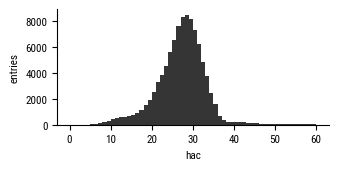

In [99]:
prop_hist(hac, np.arange(0, 60.1, 1), "hac", save_show_close=True, figname="_figures/ref_only/hac_hist.png")

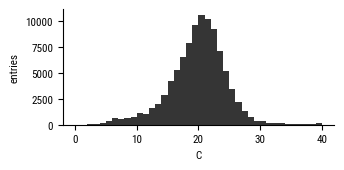

In [100]:
prop_hist(cnops[6], np.arange(0, 40.1, 1), "C", save_show_close=True, figname="_figures/ref_only/c_hist.png")

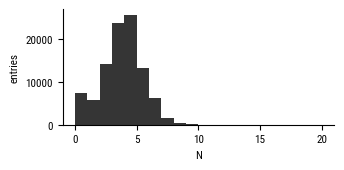

In [102]:
prop_hist(cnops[7], np.arange(0, 20.1, 1), "N", save_show_close=True, figname="_figures/ref_only/n_hist.png")

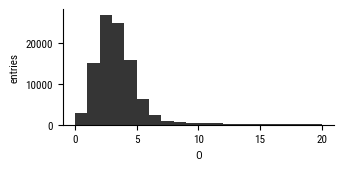

In [103]:
prop_hist(cnops[8], np.arange(0, 20.1, 1), "O", save_show_close=True, figname="_figures/ref_only/o_hist.png")

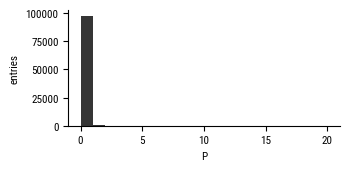

In [104]:
prop_hist(cnops[15], np.arange(0, 20.1, 1), "P", save_show_close=True, figname="_figures/ref_only/p_hist.png")

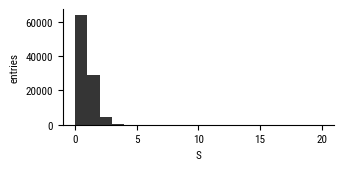

In [105]:
prop_hist(cnops[16], np.arange(0, 20.1, 1), "S", save_show_close=True, figname="_figures/ref_only/s_hist.png")

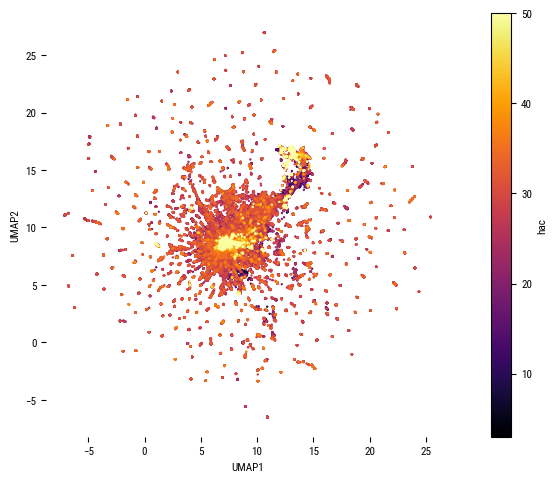

In [23]:
project_with_color_by_prop2(embedding.T[0],
                            embedding.T[1],
                            hac, "hac", vmax=50)

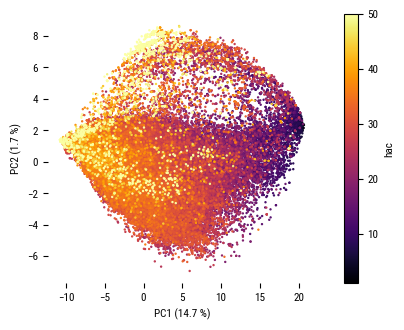

In [97]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               hac, "hac", vmax=50, figname="_figures/ref_only/PCA_1_2_color-by-hac.png")

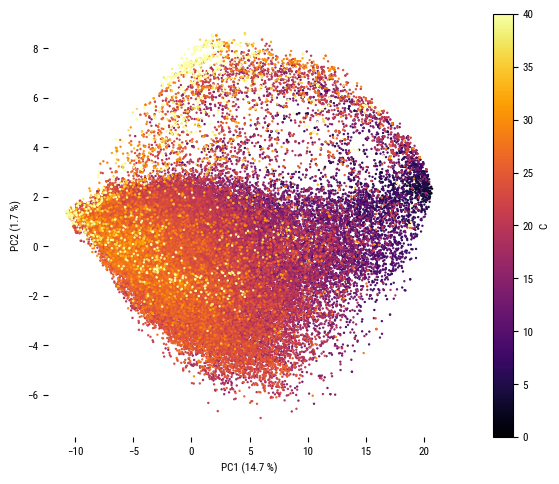

In [32]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[6], "C", vmax=40)

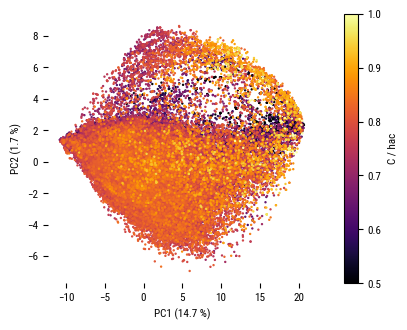

In [114]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[6] / hac, "C / hac", vmin=0.5)

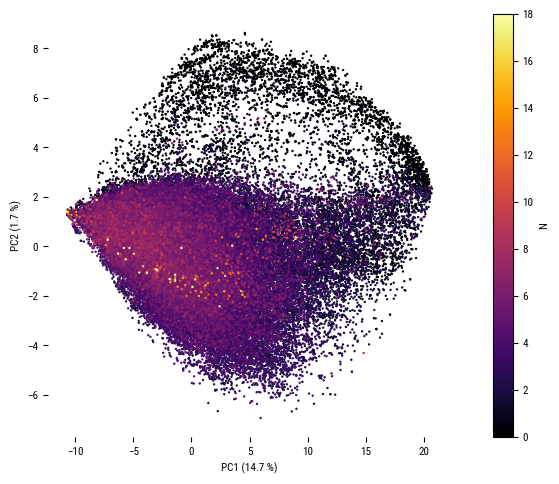

In [33]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[7], "N", vmax=18)

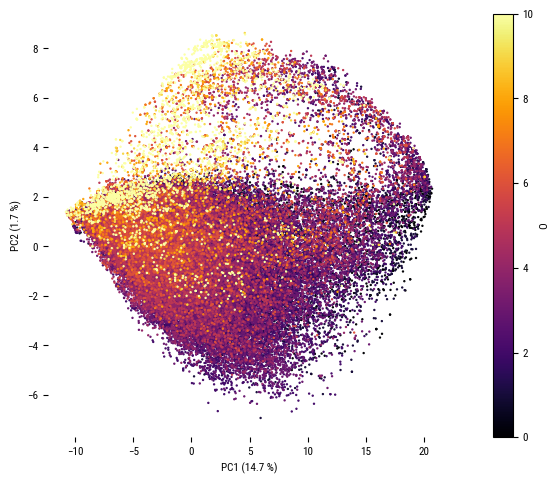

In [34]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[8], "O", vmax=10)

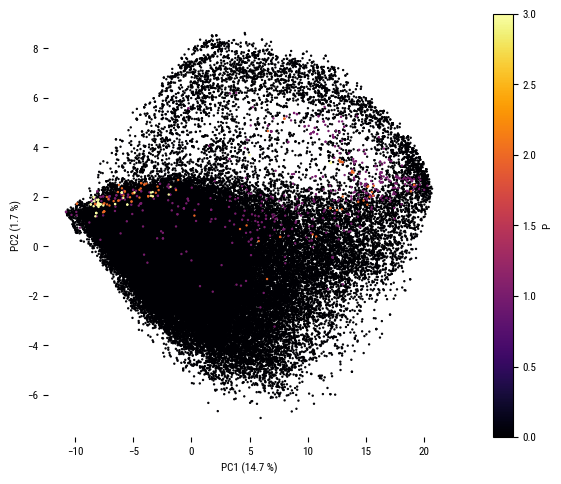

In [35]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[15], "P", vmax=3)

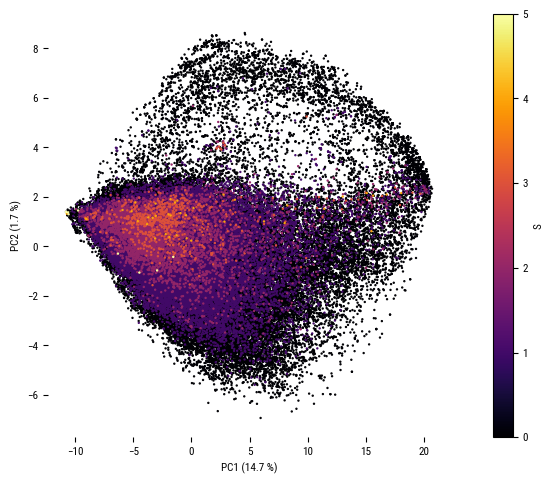

In [36]:
for i in range(1):
    project_with_color_by_prop(i + 1, fps_pca.T[i], pca.explained_variance_ratio_[i],
                               i + 2, fps_pca.T[i + 1], pca.explained_variance_ratio_[i + 1],
                               cnops[16], "S", vmax=5)

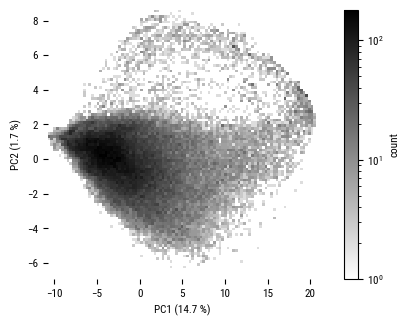

In [43]:
fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(4, 3.5), width_ratios=(20, 1))

#ax.scatter(fps_pca.T[0], fps_pca.T[1], s=1, marker=".", c="#353535", alpha=0.3, linewidths=None)
xbins = np.linspace(min(fps_pca.T[0]), max(fps_pca.T[0]), 100)
ybins = np.linspace(min(fps_pca.T[1]), max(fps_pca.T[1]), 100)
ax: mplAxes
*_, himg = ax.hist2d(fps_pca.T[0], fps_pca.T[1], (xbins, ybins), cmap="binary", norm="log")

cb = plt.colorbar(himg, cax=axcb)
cb.set_label("count")

for d in ["top", "bottom", "left", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f} %)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f} %)")
plt.savefig("_figures/PCA_comp-1-2_density.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

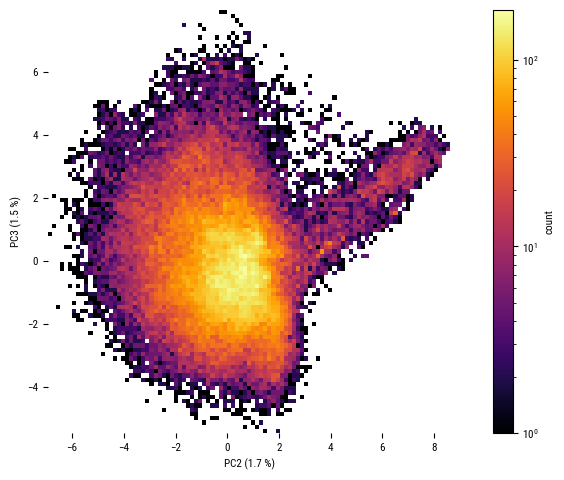

In [125]:
fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(6, 5.5), width_ratios=(20, 1))

#ax.scatter(fps_pca.T[0], fps_pca.T[1], s=1, marker=".", c="#353535", alpha=0.3, linewidths=None)
xbins = np.linspace(min(fps_pca.T[1]), max(fps_pca.T[1]), 100)
ybins = np.linspace(min(fps_pca.T[2]), max(fps_pca.T[2]), 100)
ax: mplAxes
*_, himg = ax.hist2d(fps_pca.T[1], fps_pca.T[2], (xbins, ybins), cmap="inferno", norm="log")
cb = plt.colorbar(himg, cax=axcb)
cb.set_label("count")

for d in ["top", "bottom", "left", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f} %)")
ax.set_ylabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f} %)")
plt.show()
plt.close()

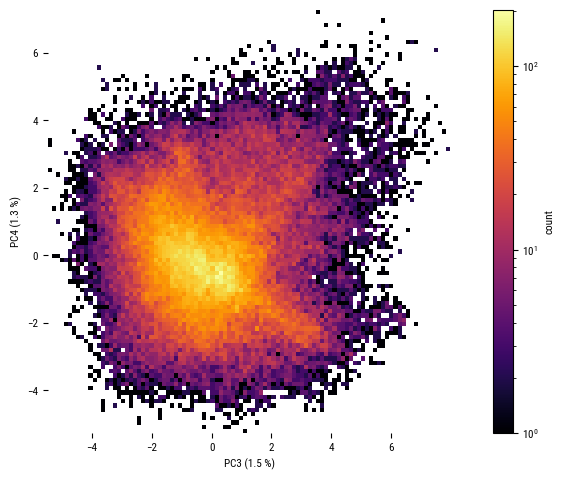

In [126]:
fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(6, 5.5), width_ratios=(20, 1))

#ax.scatter(fps_pca.T[0], fps_pca.T[1], s=1, marker=".", c="#353535", alpha=0.3, linewidths=None)
xbins = np.linspace(min(fps_pca.T[2]), max(fps_pca.T[2]), 100)
ybins = np.linspace(min(fps_pca.T[3]), max(fps_pca.T[3]), 100)
ax: mplAxes
*_, himg = ax.hist2d(fps_pca.T[2], fps_pca.T[3], (xbins, ybins), cmap="inferno", norm="log")
cb = plt.colorbar(himg, cax=axcb)
cb.set_label("count")

for d in ["top", "bottom", "left", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel(f"PC3 ({pca.explained_variance_ratio_[2] * 100:.1f} %)")
ax.set_ylabel(f"PC4 ({pca.explained_variance_ratio_[3] * 100:.1f} %)")
plt.show()
plt.close()

In [44]:
qry = """--sqlite3
SELECT 
    DISTINCT smi 
FROM 
    Compounds 
    JOIN Adducts USING(cmpd_id) 
    JOIN ClassLabels USING(cmpd_id)
    LEFT JOIN Smiles USING(smi_id) 
    LEFT JOIN InChIs USING(inchi_id) 
WHERE 
    smi IS NOT NULL 
    AND smi !="INVALID"
    AND cls_id=494
;"""
smis_peps = [_ for (_,) in cur.execute(qry).fetchall()]

In [45]:
fps_peps = np.array(
    [
        [
            int(_) 
            for _ in RDKFingerprint(
                Chem.MolFromSmiles(smi), fpSize=1024
            )
        ] 
        for smi in smis_peps
    ], 
    dtype=np.uint8
)

In [46]:
peps_proj = pca.transform(fps_peps).T

In [47]:
qry = """--sqlite3
SELECT 
    DISTINCT smi 
FROM 
    Compounds 
    JOIN Adducts USING(cmpd_id) 
    JOIN ClassLabels USING(cmpd_id)
    LEFT JOIN Smiles USING(smi_id) 
    LEFT JOIN InChIs USING(inchi_id) 
WHERE 
    smi IS NOT NULL 
    AND smi !="INVALID"
    AND cls_id=519
;"""
smis_carbs = [_ for (_,) in cur.execute(qry).fetchall()]

In [48]:
fps_carbs = np.array(
    [
        [
            int(_) 
            for _ in RDKFingerprint(
                Chem.MolFromSmiles(smi), fpSize=1024
            )
        ] 
        for smi in smis_carbs
    ], 
    dtype=np.uint8
)

In [49]:
carbs_proj = pca.transform(fps_carbs).T

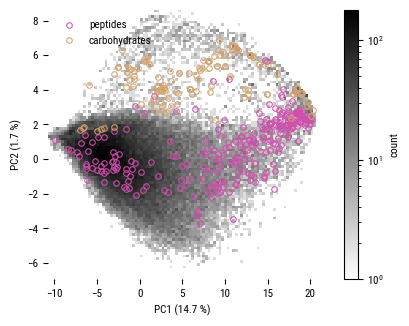

In [61]:
fig, (ax, axcb) = plt.subplots(ncols=2, figsize=(4, 3.5), width_ratios=(20, 1))

#ax.scatter(fps_pca.T[0], fps_pca.T[1], s=1, marker=".", c="#353535", alpha=0.3, linewidths=None)
xbins = np.linspace(min(fps_pca.T[0]), max(fps_pca.T[0]), 100)
ybins = np.linspace(min(fps_pca.T[1]), max(fps_pca.T[1]), 100)
ax: mplAxes
*_, himg = ax.hist2d(fps_pca.T[0], fps_pca.T[1], (xbins, ybins), cmap="binary", norm="log")
ax.scatter(peps_proj[0], peps_proj[1], s=16, marker="o", edgecolors="#D34DAE", linewidths=0.75, label="peptides", c="#00000000")
ax.scatter(carbs_proj[0], carbs_proj[1], s=16, marker="o", edgecolors="#D7A268", linewidths=0.75, label="carbohydrates", c="#00000000")
ax.legend(frameon=False)
cb = plt.colorbar(himg, cax=axcb)
cb.set_label("count")

for d in ["top", "bottom", "left", "right"]:
    ax.spines[d].set_visible(False)
ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0] * 100:.1f} %)")
ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1] * 100:.1f} %)")
plt.savefig("_figures/PCA_comp-1-2_density_peps_carbs.png", dpi=400, bbox_inches="tight")
plt.show()
plt.close()

# Expanded

In [62]:
con2 = sqlite3.connect("expanded/idpp_cleaned_expanded.db")
cur2 = con2.cursor()

In [77]:
qry = """--sqlite3
SELECT 
    adduct_mz
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_mz > 0
ORDER BY 
    adduct_mz
;"""
all_mzs2 = np.array(cur2.execute(qry).fetchall()).ravel()

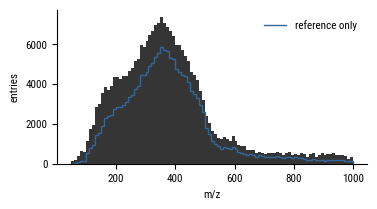

In [83]:
bins = [_ for _ in range(50, 1001, 10)]
ax = prop_hist(all_mzs2, bins, "m/z")
# customized legend
lines = [
    mplLines.Line2D([0], [0], color="#336699", lw=1., label="reference only"),
]
ax.legend(handles=lines, frameon=False, loc="upper right")
prop_hist(all_mzs, bins, None, color="#336699", step=True, figname="_figures/expand/mz_dist.png", 
          save_show_close=True, ax=ax)

In [82]:
qry = """--sqlite3
SELECT 
    ccs
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
    JOIN CCSs USING(adduct_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND ccs != 107.820244  -- DarkChem predicted a ton of entries with this value, must be an error
ORDER BY 
    ccs
;"""
all_ccs2 = np.array(cur2.execute(qry).fetchall()).ravel()

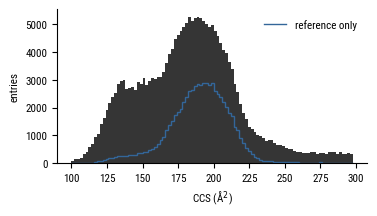

In [84]:
bins = [_ for _ in range(100, 300, 2)]
ax = prop_hist(all_ccs2, bins, "CCS (Å$^2$)")
# customized legend
lines = [
    mplLines.Line2D([0], [0], color="#336699", lw=1., label="reference only"),
]
ax.legend(handles=lines, frameon=False, loc="upper right")
prop_hist(all_ccs, bins, None, color="#336699", step=True, figname="_figures/expand/ccs_dist.png", 
          save_show_close=True, ax=ax)

(186)
(374, 375)
(366, 367)
(260, 261)


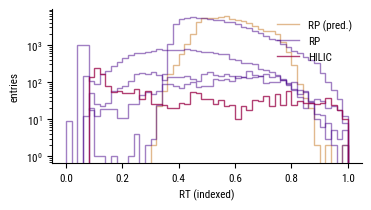

In [75]:
qry_fetch_rts_by_src_ids = """--sqlite3
SELECT 
    rt
FROM
    RTs
WHERE
    src_id IN {}
;"""

bins = np.arange(0, 1.01, 0.02)
ax = prop_hist(None, None, "RT (indexed)", log_y=True)
# RP (pred)
rts = np.array(cur2.execute(qry_fetch_rts_by_src_ids.format("(408)")).fetchall()).ravel()
prop_hist(rts / max(rts), bins, None, ax=ax, step=True, color="#D7A268", alpha=0.75)
# RP
# 186
# 374, 375
# 366, 367
# 260, 261
for src_ids in [
    "(186)", 
    (374, 375), 
    (366, 367), 
    (260, 261)
]:
    print(src_ids)
    rts = np.array(
        cur2.execute(
            qry_fetch_rts_by_src_ids.format(src_ids)
        ).fetchall()
    ).ravel()
    prop_hist(rts / max(rts), bins, None, ax=ax, step=True, color="#440088", alpha=0.5)
# HILIC
# 227, 224
rts = np.array(cur2.execute(qry_fetch_rts_by_src_ids.format((227, 224))).fetchall()).ravel()
prop_hist(rts / max(rts), bins, None, ax=ax, step=True, color="#990044", alpha=0.75)
#ax.set_ylim([0, 200])
# customized legend
lines = [
    mplLines.Line2D([0], [0], color="#D7A268", lw=1., alpha=0.75, label="RP (pred.)"),
    mplLines.Line2D([0], [0], color="#440088", lw=1., alpha=0.5, label="RP"),
    mplLines.Line2D([0], [0], color="#990044", lw=1., alpha=0.75, label="HILIC")
]
ax.legend(handles=lines, frameon=False, loc="upper right")
prop_hist(None, None, None, ax=ax, save_show_close=True, figname="_figures/expand/RT_indexed_hists.png")

In [63]:
qry = """--sqlite3
SELECT 
    adduct_mz,
    frag_imz
FROM 
    Adducts
    JOIN Compounds USING(cmpd_id)
    JOIN MS2Spectra USING(adduct_id)
    JOIN MS2Fragments USING(ms2_id)
WHERE 
    cmpd_id >= 0
    AND adduct_id >= 0
    AND adduct != "none"
    AND adduct_mz > 0
;"""
pres, frags = np.array(cur2.execute(qry).fetchall()).T

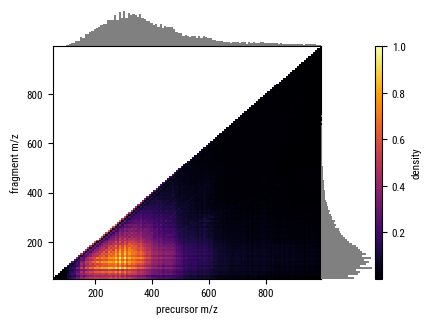

In [70]:
ms2_2d_hist(pres, frags / 1e5, figname="_figures/expand/msms_precursors_fragments_2d_hist.png")